In [1]:
import matplotlib.pyplot as plt
from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord
from astropy import coordinates as coords
from astroquery.sdss import SDSS
from astropy.wcs import WCS
import astropy.units as u
from astropy.io import fits

import numpy as np

import petrofit as pf

#from datetime import datetime

In [2]:
pos = coords.SkyCoord(ra=189.183288812633, dec=14.6450833, unit="deg", frame='icrs')
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)

hdu = SDSS.get_images(matches=xid,band='g')[0][0]

xid


# pos = coords.SkyCoord(ra=165.19983, dec=10.72816, unit="deg", frame='icrs',)
# xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)

# hdu = SDSS.get_images(matches=xid,band='g')[0][0]

# xid

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64
189.183288812633,14.645083328157,1237661069265010799,3631,301,3,479,0.04618024,1769,53502,273,1991792035627034624,26


In [3]:
#hdu.header

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(121.0040480319019, 521.0040480319019)

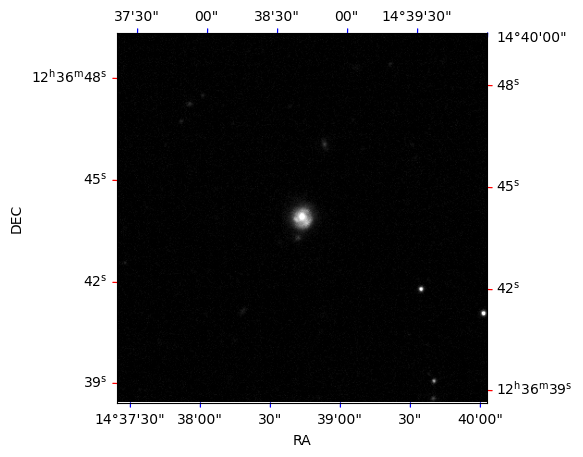

In [4]:
wcs = WCS(hdu.header, relax=True)
ax=plt.subplot(projection=wcs)
ax.imshow(hdu.data, cmap='grey' ,vmin=0,vmax=0.7)
#ax.colorbar()
#plt.scatter(1025,745,marker='.')
lon, lat = ax.coords
lon.set_ticks(color='red')
lon.set_ticks_position('lbtr')
lon.set_ticklabel_position('lbtr')
lat.set_ticks(color='blue')
lat.set_ticks_position('lbtr')
lat.set_ticklabel_position('lbtr')
plt.xlabel('RA')
plt.ylabel('DEC')

b=200
a=200

x,y=wcs.world_to_pixel(pos)
plt.xlim(x-a,x+a)
plt.ylim(y-b,y+b)
#plt.scatter(x,y)

In [5]:
from photutils.background import Background2D, MedianBackground

data = hdu.data

bkg_estimator = MedianBackground()

bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)


b1=int(x-a)
b2=int(x+a)
a1=int(y-b)
a2=int(y+b)

data = data - bkg.background  # subtract the background
data=data[a1:a2,b1:b2]


In [6]:
threshold = 1.5 * bkg.background_rms

threshold = threshold[int(y-b):int(y+b),int(x-a):int(x+a)]

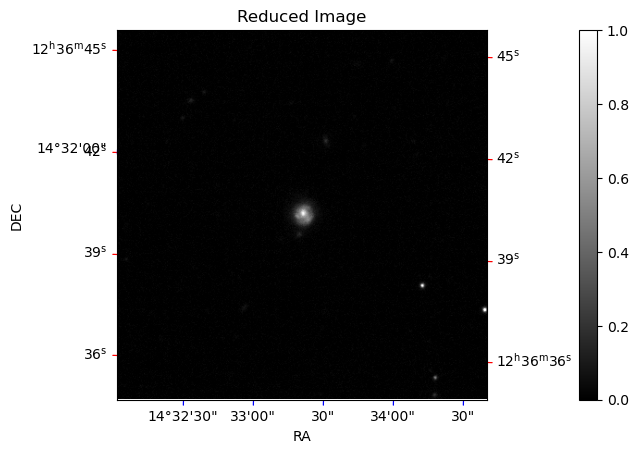

In [7]:
ax =plt.subplot(projection=wcs)
pos=ax.imshow(data, cmap='grey' ,vmin=0,vmax=1)

plt.colorbar(pos, ax=ax, location='right', anchor=(1.2, 0.3))

lon, lat = ax.coords
lon.set_ticks(color='red')
lon.set_ticks_position('lbtr')
lon.set_ticklabel_position('lbtr')
lat.set_ticks(color='blue')
lat.set_ticks_position('lbr')
lat.set_ticklabel_position('lbr')
plt.xlabel('RA')
plt.ylabel('DEC')
ax.set_title('Reduced Image')

plt.savefig("ReducedImage.pdf",format='pdf')

In [8]:
from astropy.convolution import convolve

from photutils.segmentation import make_2dgaussian_kernel

kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0

convolved_data = convolve(data, kernel)

In [9]:
from photutils.segmentation import detect_sources

segment_map = detect_sources(convolved_data, threshold, npixels=10)

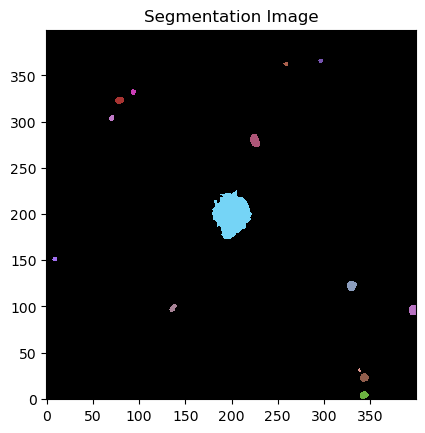

In [10]:
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

#ax1.imshow(data, vmin=0, vmax=1,origin='lower', cmap='Greys_r')

#ax1.set_title('Background-subtracted Data')

# ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,

#            interpolation='nearest')

# ax2.set_title('Segmentation Image')


plt.imshow(segment_map, origin='lower', cmap=segment_map.cmap,

           interpolation='nearest')

plt.title('Segmentation Image')

plt.savefig('SegmentationImage.pdf',format='pdf')

In [11]:
from photutils.segmentation import deblend_sources

segm_deblend = deblend_sources(convolved_data, segment_map,

                               npixels=10, nlevels=32, contrast=0.001,

                               progress_bar=False)

In [12]:
from photutils.segmentation import SourceFinder

finder = SourceFinder(npixels=10, progress_bar=False)

segment_map = finder(convolved_data, threshold)

segment_map

<photutils.segmentation.core.SegmentationImage>
shape: (400, 400)
nlabels: 15
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

In [13]:
from photutils.segmentation import SourceCatalog

cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)

cat

<photutils.segmentation.catalog.SourceCatalog>
Length: 15
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

In [14]:
tbl = cat.to_table()

tbl['xcentroid'].info.format = '.2f'  # optional format

tbl['ycentroid'].info.format = '.2f'

tbl['kron_flux'].info.format = '.2f'

tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,343.09,3.80,None,339,348,0,8,65.0,2.0146175852990855,1.8037568501907295,25.871314270444824,0.44539413556518853,-0.0032215118408203125,0.2126293182373047,0.0,3.7546490140415285,nan,5.50,nan
2,343.70,22.62,None,340,348,18,27,67.0,1.8678763997854169,1.6984901106597963,70.7052207019645,0.41610600029507905,0.0037479400634765625,0.4841136932373047,0.0,6.752130508422852,nan,7.36,nan
3,338.44,30.20,None,337,340,29,32,11.0,1.0908760879310269,0.7300941688341319,-40.887096813217575,0.743016376887602,0.0072383880615234375,0.06638908386230469,0.0,0.4484729766845703,nan,1.08,nan
4,396.72,95.97,None,392,399,91,101,79.0,2.002831457132748,1.6080077678181095,87.08938669242161,0.5961578582998462,-0.020886869058471702,1.4267889397662612,0.0,17.7404078349285,nan,18.01,nan
5,137.14,98.24,None,133,141,94,102,53.0,2.4826912558776817,1.4359865346906975,50.32200505516261,0.8157538922732018,-0.003486824976660894,0.10418207233172173,0.0,2.179709148789985,nan,3.07,nan
6,329.75,122.15,None,325,335,117,127,96.0,1.9813836454298355,1.887714637999606,74.55240884368058,0.30383252727024784,-0.013922011417575984,1.1532478168507074,0.0,15.369416119142272,nan,15.76,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,79.24,322.18,None,75,83,319,325,52.0,2.02392344851709,1.5755503214079327,10.680078191088935,0.6276900037091352,-0.010437345936487343,0.13559253310318525,0.0,2.73074882956045,nan,4.13,nan


In [15]:
#Only works for full image as x,y changes when image dim changed
# Starx, Stary = x,y
# for i in tbl:
#     x1=i[1]
#     y1=i[2]
#     if Starx > (x1-5) and Starx < (x1+5):
#         print()
#     if Stary > (y1-5) and Stary < (y1+5):
#         print(i[0])

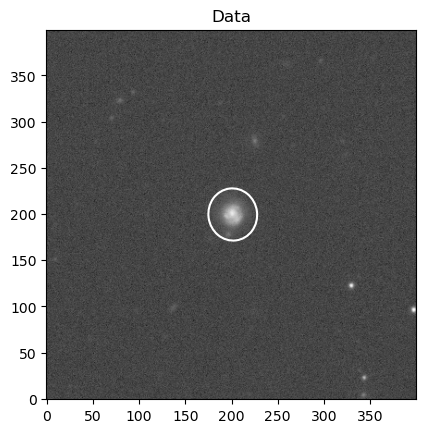

In [16]:
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt')

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

# ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)

# ax1.set_title('Data')

# ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,interpolation='nearest')

# ax2.set_title('Segmentation Image')

# cat[14].plot_kron_apertures(ax=ax1, color='white', lw=1.5)

# cat[14].plot_kron_apertures(ax=ax2, color='white', lw=1.5)

plt.imshow(data, origin='lower', cmap='Greys_r', norm=norm)

plt.title('Data')

cat[14].plot_kron_apertures(color='white', lw=1.5)

plt.savefig('KronAperture.pdf',format='pdf')

In [17]:
#kron flux to magnitude using m=−2.5log10​(F)+ZP
#Kron flux no good? Misses half of light? 
zp=22.5
f=237.30 #+3.5

In [18]:
def m(f):
    return -2.5*np.log10(f)+zp

In [19]:
ABmag=m(f)
print(ABmag)

16.561755654456654


In [20]:
def nmaggie(m):
    return 10**(-0.4*m)*1E9

In [21]:
nmaggie(ABmag)

237.2999999999993

# Radial Profile

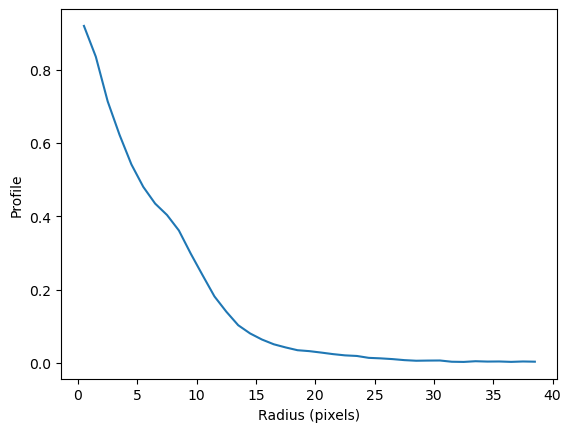

In [22]:
from photutils.profiles import RadialProfile

#img = plt.imread()
center = (201.24,199.50)
edge_radii = np.arange(40)
rp = RadialProfile(data, center, edge_radii)

rp.plot(label='Radial Profile')

plt.savefig('RadialProfile.pdf',format='pdf')

# Isopotes

In [23]:
from photutils.isophote import Ellipse

from photutils.isophote import EllipseGeometry

In [24]:
ellipse = Ellipse(data)
isolist = ellipse.fit_image()

In [25]:
#isolist.to_table()

In [26]:
type(isolist)

photutils.isophote.isophote.IsophoteList

In [27]:
isophote = ellipse.fit_isophote(sma=20.)

isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
20.0,0.04496874264693713,0.0018097452372514177,0.21603577025833604,0.042665474931847955,69.98538428661531,6.362034680047401,-0.004793628784572296,0.0014241888091243164,0.29710035405909874,200.80222582118063,0.45145340532367206,198.49314168026459,0.5184304538541541,111,0,12,0


In [28]:
# user defines here the geometry parameters that will be used as first guess.
x0 = 201.24    # center position
y0 = 199.5    # center position
sma = 7.4    # semimajor axis length in pixels
eps = 0.36    # ellipticity

# positon angle is defined in radians, counterclockwise from the
# +X axis (rotating towards the +Y axis). Here we use 35 degrees 
# as a first guess.
pa = 35. / 180. * np.pi

# note that the EllipseGeometry constructor has additional parameters with
# default values. Please see the documentation for details.
g = EllipseGeometry(x0, y0, sma, eps, pa)

# the custom geometry is passed to the Ellipse constructor.
ellipse = Ellipse(data, geometry=g)

# the fit proceeds as usual.
isophote = ellipse.fit_isophote(sma=20.)

print(isophote)


sma         intens             intens_err      ... nflag niter stop_code
                                               ...                      
---- -------------------- -------------------- ... ----- ----- ---------
20.0 0.040519487776864274 0.001736518195238934 ...     0    50         2


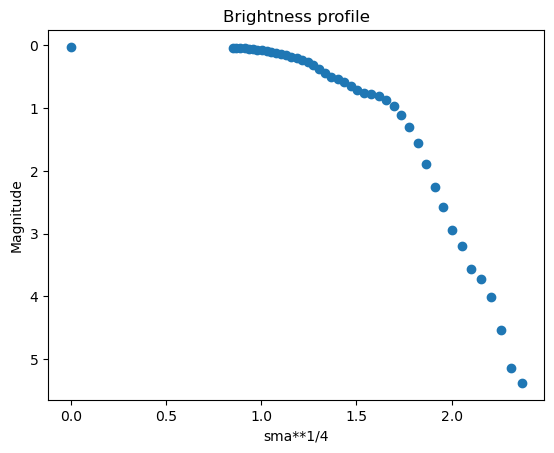

In [29]:
plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))
plt.title("Brightness profile")
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()


Text(0.5, 1.0, 'Residual')

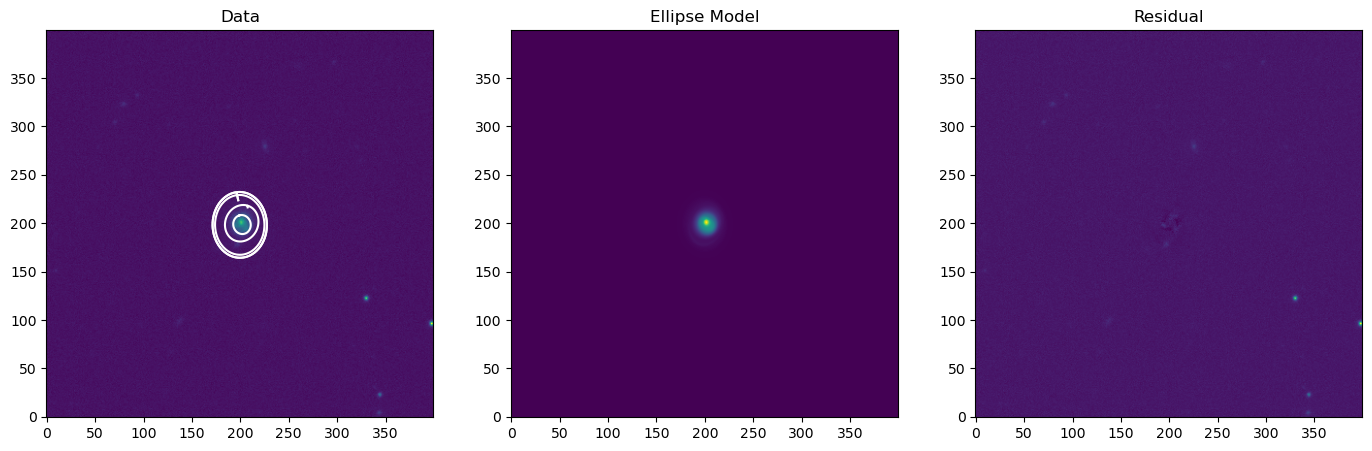

In [30]:
from photutils.isophote import build_ellipse_model

geometry = EllipseGeometry(x0=x0, y0=y0, sma=sma, eps=eps,
                           pa=pa)
ellipse = Ellipse(data, geometry)
isolist = ellipse.fit_image()

model_image = build_ellipse_model(data.shape, isolist)
residual = data - model_image

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower')
ax1.set_title('Data')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')

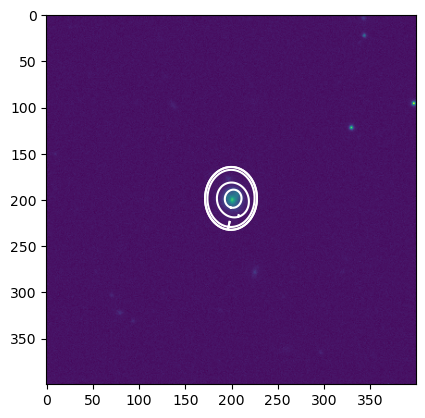

In [51]:
plt.imshow(data)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')

# PetroFit